In [17]:
import matplotlib.pyplot as plt
import os
import pandas as pd

from scipy.stats import f_oneway, anderson, spearmanr

import seaborn as sns


In [2]:
data_path = os.path.join("..", "data", "01_raw")
print(f"Data path: {data_path}")

Data path: ..\data\01_raw


Is there any correlation between soil, CO2 and fertilizer with the yields?

In [3]:
train_solutions_wheat_df = pd.read_parquet(os.path.join(data_path, 'train_solutions_wheat.parquet'))
train_solutions_maize_df = pd.read_parquet(os.path.join(data_path, 'train_solutions_maize.parquet'))

In [4]:
soil_co2_wheat_train_df = pd.read_parquet(os.path.join(data_path, 'soil_co2_wheat_train.parquet'))
soil_co2_maize_train_df = pd.read_parquet(os.path.join(data_path, 'soil_co2_maize_train.parquet'))

In [5]:
wheat_joined_df = train_solutions_wheat_df.join(soil_co2_wheat_train_df) 
maize_joined_df = train_solutions_maize_df.join(soil_co2_maize_train_df) 

In [6]:
df_list = [wheat_joined_df, maize_joined_df] # add more DataFrames as needed
df_names = ['wheat', 'maize']

variables_list = ['yield', 'co2', 'nitrogen', 'real_year', 'lat', 'lon']

But first, are the variables normally distributed?

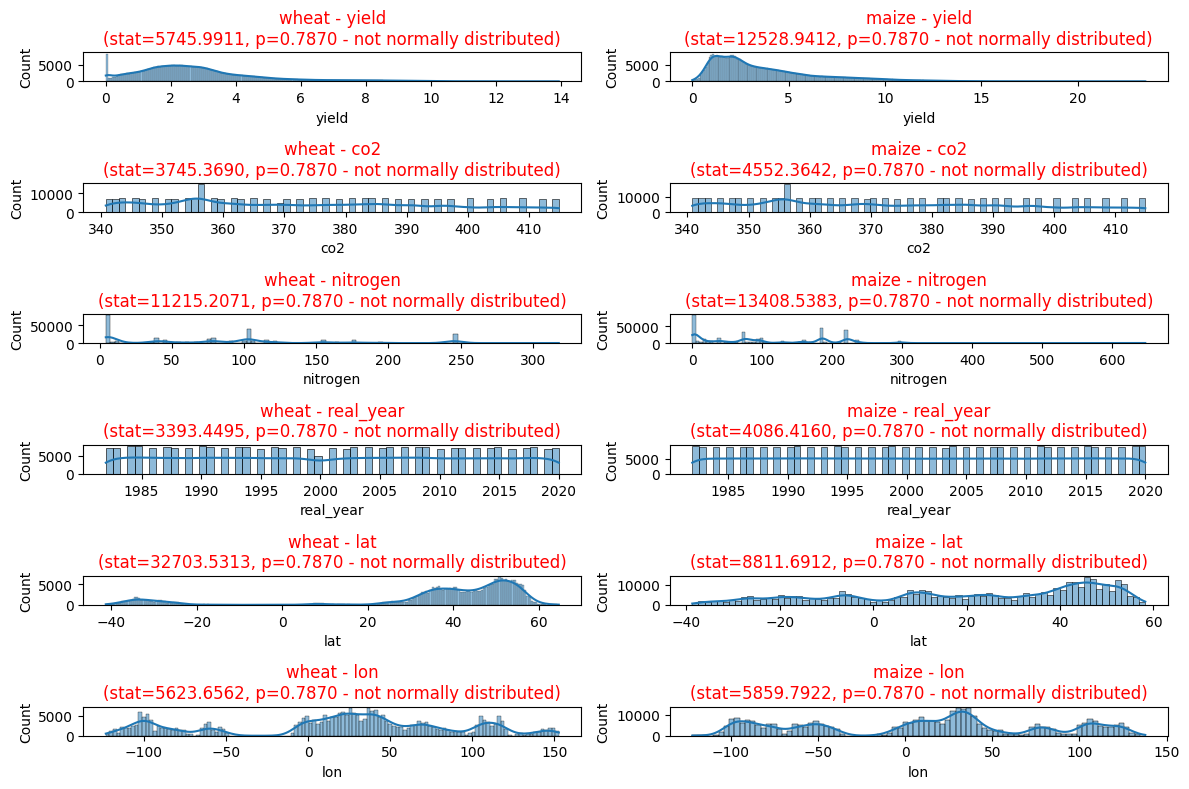

In [14]:
fig, axes = plt.subplots(nrows=len(variables_list), ncols=len(df_list), figsize=(12, 8))

for i, var in enumerate(variables_list):
    for j, df in enumerate(df_list):
        result = anderson(df[var], dist='norm')  # We should use the Anderson test because N > 5000
        stat = result.statistic
        p = result.critical_values[2]  # p-value for 5% significance level
        normality_status = "normally distributed" if stat < p else "not normally distributed"
        color = 'green' if stat < p else 'red'
        title = f"{df_names[j]} - {var}\n(stat={stat:.4f}, p={p:.4f} - {normality_status})"

        
        sns.histplot(df[var], kde=True, ax=axes[i, j])
        axes[i, j].set_title(title, color=color)

plt.tight_layout()
plt.show()


Numerical variables are not normally distributed

---

In [ ]:
for i, df in enumerate(df_list):
    print(f"Observed values for each texture_class category for {df_names[i]}\n{df['texture_class'].value_counts()}")
    expected_values_count = int(len(df)/df['texture_class'].nunique())
    print(f"\nEach texture_class should have {expected_values_count} values\n\n####\n")

Observed values for each texture_class category for wheat
texture_class
9.0     160216
7.0      42120
3.0      24176
5.0      13730
11.0     11415
12.0      7574
10.0      6079
2.0       5903
1.0       3534
13.0      2544
4.0       1456
Name: count, dtype: int64

Each texture_class should have 25340 values

####

Observed values for each texture_class category for maize
texture_class
9.0     141624
3.0      46142
10.0     40626
7.0      30980
11.0     28957
5.0      12656
12.0     12348
1.0      11172
13.0     10270
2.0       7879
8.0       4939
4.0       2126
Name: count, dtype: int64

Each texture_class should have 29143 values

####



texture_class variables are not evenly distributed for wheat or maize. 

We should take that in consideration in the statistical tests

---
Now let's do simple correlation tests:

In [ ]:
wheat_corr_matrix = wheat_joined_df[['yield', 'lon', 'lat', 'texture_class', 'real_year', 'co2', 'nitrogen']].corr(method="spearman") # We use spearman correlation method because all the variables are not normally distributed.
maize_corr_matrix = maize_joined_df[['yield', 'lon', 'lat', 'texture_class', 'real_year', 'co2', 'nitrogen']].corr(method="spearman") # We use spearman correlation method because all the variables are not normally distributed.

First, for wheat

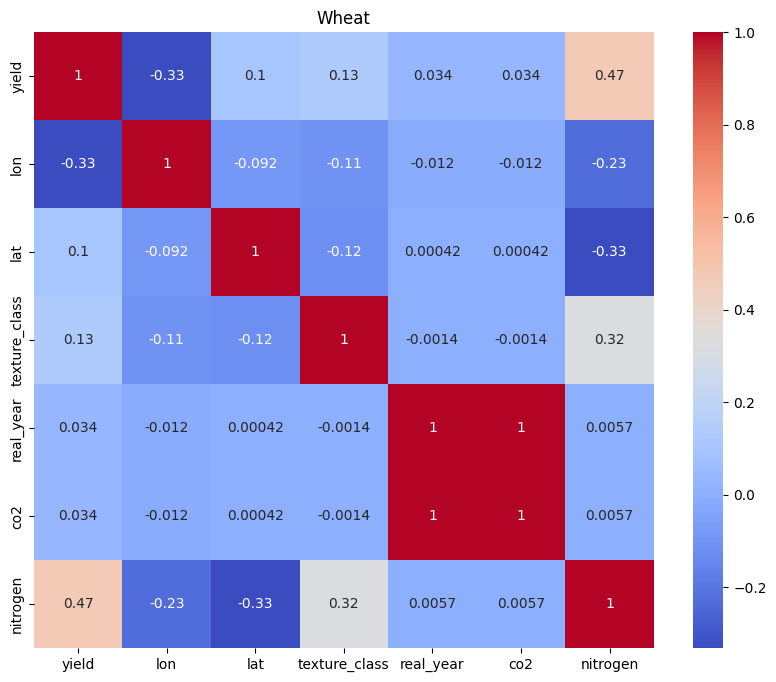

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(wheat_corr_matrix, annot=True, cmap='coolwarm')
plt.title("Wheat")
plt.show()

For wheat, yield is highly correlated with fertilization (r2=0.47), then a bit with the texture class as a numerical variable (r2=0.13).  
It is also correlated with the latitude and longitude (r2=0.1 and -0.33).  

It doesn't seem like it's correlated with the year or the level of CO2.  
However, CO2 level and real yearly are 100% correlated (r2=1). We should investigate this.

Soil texture is correlated with fertilization (r2=0.32). We should then be careful and be sure we want to use both variables in our model.
Fertilisation seems also correlated with longitude and latitude (r2=-0.23 and 0.33). We should check if this is not a random correlation

- We could also try to look for a correlation between texture_class as a categorical value not ordered.
- We could create another variable to group latitude and longitude and assess the correlation again.  

---
Then, let's look at the maize

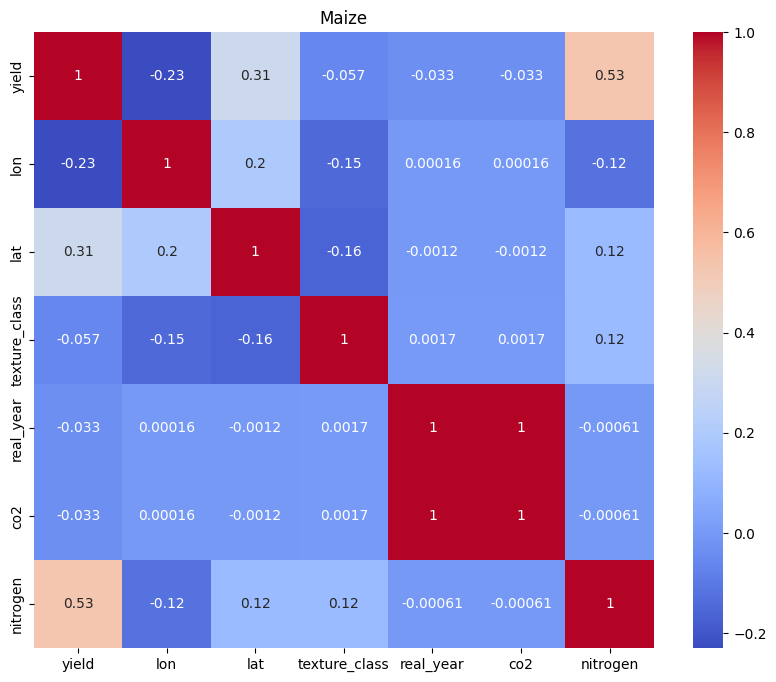

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(maize_corr_matrix, annot=True, cmap='coolwarm')
plt.title("Maize")
plt.show()

For maize, yield is highly correlated with fertilization (r2=0.53), but in contrast to wheat, it is not with the texture class as a numerical variable (r2=-0.057).  
It is also more correlated with the latitude and longitude (r2=0.31 and -0.23).  

It doesn't seem like it's correlated with the year or the level of CO2.  
However, CO2 level and real yearly are 100% correlated (r2=1). We should investigate this.

However, soil texture is a bit correlated with fertilization (r2=0.12). We should then be careful and be sure we want to use both variables in our model.  
Fertilization is also a bit correlated with latitude and longitude (r2=0.12 and -0.12). We should check if this is a random correlation or not.

- We could also try to look for a correlation between texture_class as a categorical value not ordered.
- We could create another variable to group latitude and longitude and assess the correlation again.  

---

Is there any correlation between texture_class as a categorical not ordered variable?

wheat
F-value: 1618.0612918510628, p-value: 0.0
maize
F-value: 4324.541965885588, p-value: 0.0


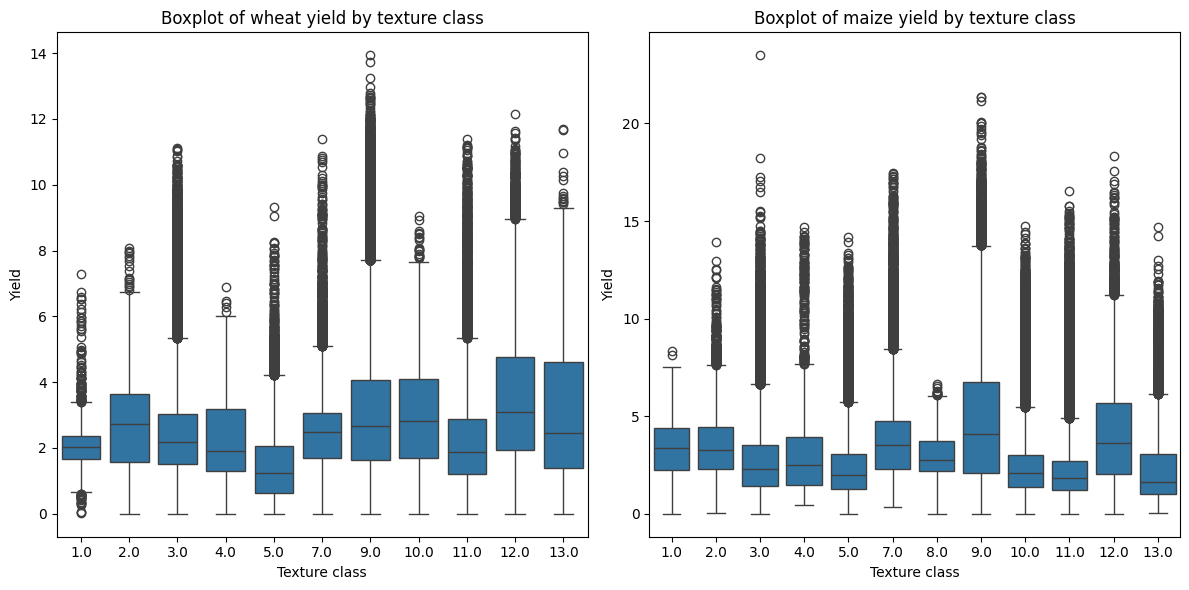

In [ ]:
# Create figure with 2x1 subplots
fig, axs = plt.subplots(1, len(df_list), figsize=(12, 6))

for i, df in enumerate(df_list):
    groups = df.groupby('texture_class')['yield'].apply(list)
    F_value, p_value = f_oneway(*groups)
    print(f"{df_names[i]}\nF-value: {F_value}, p-value: {p_value}")

    sns.boxplot(x='texture_class', y='yield', data=df, ax=axs[i])
    axs[i].set_title(f'Boxplot of {df_names[i]} yield by texture class')
    axs[i].set_xlabel('Texture class')
    axs[i].set_ylabel('Yield')

plt.tight_layout()
plt.show()


Seems like there is, we could then use this variable as a not ordered categorical variable in the model.

---

Is there a good way to group latitude and longitude in a single variable and have it correlated with the yield?

We will try 3 strategies:
- Geohash Encoding (May lose some granularity depending on the precision level chosen and may not capture the continuous nature of geographical data)
- Distance from a Reference Point (Choice of reference point can affect the results)
- Principal Component Analysis (Less interpretable and may not capture the exact geographical relationship) 

In [15]:
import pygeohash as pgh

# Function to encode geohash with a given precision
def encode_geohash(df, precision):
    df['geohash'] = df.apply(lambda row: pgh.encode(row['lat'], row['lon'], precision=precision), axis=1)
    return df

Precision 1: 5000 km x 5000 km.   
Precision 2: 1200 km x 600 km.  
Precision 3: 156 km x 156 km.  
Precision 4: 39.1 km x 19.5 km.  
Precision 5: 4.9 km x 4.9 km.  
Precision 6: 1.2 km x 0.61 km.  
Precision 7: 152 m x 152 m.  
Precision 8: 38.2 m x 19.1 m.  
Precision 9: 4.77 m x 4.77 m.  
Precision 10: 1.19 m x 0.596 m.  
Precision 11: 149 mm x 149 mm.  
Precision 12: 37.2 mm x 18.6 mm.

For Geohash, we need to choose a granularity level.
We will try 4 strategies:
- Domain Knowledge: Use domain knowledge to determine the appropriate level of granularity (1ha?)
- Cross-Validation: Test different granularity and assess the best correlation with target variable
- Clustering Analysis: Determine the optimal number of clusters (geohashes) with elbow method

In [21]:
# Domain knowledge
for df in df_list:
    df = encode_geohash(df, precision=7)

    # Convert geohash to dummy variables
    df_encoded = pd.get_dummies(df['geohash'], prefix='geohash')

    # Compute Spearman correlation with the target variable 'yield'
    for col in df_encoded.columns:
        correlation, p_value = spearmanr(df['yield'], df_encoded[col])
        print(f"Geohash {col} - Spearman Correlation: {correlation}, p-value: {p_value}")

KeyboardInterrupt: 

In [ ]:
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# List of precisions to test
precisions = [4, 5, 6, 7]
best_precision = None
best_score = -float('inf')

for precision in precisions:
    df_encoded = encode_geohash(df.copy(), precision)
    X = pd.get_dummies(df_encoded['geohash'])
    y = df_encoded['yield']
    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    avg_score = scores.mean()
    if avg_score > best_score:
        best_score = avg_score
        best_precision = precision

print(f"Best Geohash Precision: {best_precision}, Best Score: {best_score}")


In [23]:
# Clustering analysis
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# List of precisions to test
precisions = [4, 5, 6, 7]
inertia_values = []

for precision in precisions:
    df_encoded = encode_geohash(df.copy(), precision)
    X = df_encoded[['lat', 'lon']]
    kmeans = KMeans(n_clusters=len(df_encoded['geohash'].unique()))
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

plt.plot(precisions, inertia_values, marker='o')
plt.xlabel('Geohash Precision')
plt.ylabel('Inertia')
plt.title('Elbow Method for Geohash Precision')
plt.show()


KeyboardInterrupt: 

Distance from a reference point

In [24]:
from geopy.distance import geodesic

reference_point = (df['latitude'].mean(), df['longitude'].mean())
df['distance'] = df.apply(lambda row: geodesic((row['latitude'], row['longitude']), reference_point).km, axis=1)

ModuleNotFoundError: No module named 'geopy'

PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
df['pca_component'] = pca.fit_transform(df[['latitude', 'longitude']])

Prochaines étapes :
- Implémenter ACP et point de référence
- Implémenter Geohash avec plusieurs stratégies de précision
=> au final, 1 colonne ACP, 1 colonne point de référence, 1 colonne par préicision par stratégie de précision pour géohash (4 précisions à chaque fois, 3 stratégies => 12 colonnes) 
- Pour chaque stratégie, définir un test statistique le plus approprié pour voir si corrélation avec target ou non